In [93]:
import numpy as np
from icecream import ic
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [94]:
plt.rc('text', usetex=True)
plt.rc('font', family='STIXGeneral')

## Kinetische Impulsbestimmung

Skalierungsfaktor $s_P$
\begin{align}
    s_P &= \frac{L_{1}}{30.01cm} - \frac{1}{30.01cm}\frac{L_{1} - L_{2}}{2} \\
    \Delta s_{P} &= \sqrt{ \left(\frac{\partial s_{P}}{\partial L_{1}} \Delta L_{1}\right)^{2} + 
                           \left(\frac{\partial s_{P}}{\partial L_{2}} \Delta L_{2}\right)^{2}}
\end{align}

Krümmungsradius $r_{real}$ in $cm$
\begin{align}
    r_{real} &= \frac{r_{gemessen}}{s_{P}} \\
    \Delta r_{real} &= \sqrt{ \left( \frac{\partial r_{real}}{\partial r_{gem}} \Delta r_{gem} \right)^2 + \left( \frac{\partial r_{real}}{\partial s_{P}} \Delta s_{P} \right)^2 } \\
                    &= \sqrt{\left(\frac{\Delta r_{gem}}{s_{P}}\right)^2 + \left( \frac{r_{gem}}{s_{P}^2} \Delta s_{P} \right)^2}
\end{align}

Impuls $p$ in $\frac{MeV}{c}$
\begin{align}
    p & = 2.998 \cdot B[T] \cdot r_{real}[cm] \frac{MeV}{c\cdot cm \cdot T} \\
    \Delta p &= \sqrt{ \left( \frac{\partial p}{\partial r_{real}} \Delta r_{real} \right)^2 } \\
             &= \sqrt{2.998 \cdot 2.05 \cdot \Delta r_{real}}
\end{align}

In [95]:
# Positionen, Einheit in cm
l1 = 45.5 
delta_l1 = 0.1
l2 = 59
delta_l2 = 0.1

# Skalierungsfaktor s_p
s_p = l1 - (l1 - l2)/2
s_p = s_p/30.01

ic(s_p)

# Fehler Skalierungsfaktor
delta_s_p_inner_term = (delta_l1 / (2*30.01))**2 + (delta_l2 / (2*30.01))**2
delta_s_p = np.sqrt(delta_s_p_inner_term)
ic(delta_s_p)

# Krümmungsradius
def r_real(r_gem): 
    return r_gem / s_p # Krümmungsradius r_real in cm

# Fehler Krümmungsradius
def delta_r_real(r_gem, delta_r_gem):
    delta_r_real_inner_term = (delta_r_gem / s_p)**2 + ( (r_gem / s_p**2) * delta_s_p)**2
    delta_r_real_complete_term = np.sqrt(delta_r_real_inner_term)
    return delta_r_real_complete_term

# Impuls, kinetischer Ausdruck in MeV/c
B = 2.05 # Magnetische Flussstärke in T
def momentum(r_real):
    return 2.998 * B * r_real


# Fehler Impuls, kinetischer Ausdruck
def delta_momentum(delta_r_real):
    return 2.998 * B * delta_r_real

# Alles in einem
dfs = [] # Gesamtdataframe für alle Topologien
def parameterset(r_gem, delta_r_gem, charge, bubble, delta_bubble, angle):
    
    # ic(r_real(r_gem))
    # ic(delta_r_real(r_gem, delta_r_gem))
    # ic(momentum(r_real(r_gem)))
    # ic(delta_momentum(delta_r_real(r_gem, delta_r_gem)))

    # Array
    r_gem_array = np.atleast_1d(r_gem)  
    delta_r_gem_array = np.atleast_1d(delta_r_gem)  

    # Tabellierung
    # Um nur die Tabelle aufzurufen, gebe ein: parameterset(r_gem, delta_r_gem)[4]
    r_real_values = r_real(r_gem_array)
    delta_r_real_values = delta_r_real(r_gem_array, delta_r_gem_array)
    momentum_values = momentum(r_real_values)
    delta_momentum_values = delta_momentum(delta_r_real_values)
    
    df = pd.DataFrame({
        "charge": charge,
        "r_gem": r_gem_array,
        "delta_r_gem": delta_r_gem_array,
        "r_real": r_real_values,
        "delta_r_real": delta_r_real_values,
        "angle": angle,
        "delta_angle": np.float64(10),
        "momentum": momentum_values,
        "delta_momentum": delta_momentum_values,
        "rho" : bubble,
        "delta_rho": delta_bubble
    }, index=np.arange(1, len(r_gem_array) + 1))

    dfs.append(df)
    
    return r_real(r_gem), delta_r_real(r_gem, delta_r_gem), momentum(r_real(r_gem)), delta_momentum(delta_r_real(r_gem, delta_r_gem)), df

ic| s_p: 1.7410863045651448
ic| delta_s_p: 0.0023562371915579724


## Bläschendichte und die Bethe-Bloch Formel
Bläschendichte $\rho_{Bl}$ wird abgelesen und mit Vergrößerungsfaktor skaliert. Daher gibt es zwei Fehler: Fehler des Vergrößerungsfaktors und Fehler aus dem Ablesen
\begin{align}
    \rho_{Bl,gem} &= \Delta \rho_{sys} + \Delta \rho_{stat} \\
    \rho_{Bl} &= \frac{\rho_{Bl, gem}}{s_P} \\
    \Delta \rho_{Bl} &= \sqrt{ \left( \frac{1}{s_P}\Delta \rho_{Bl, gem} \right)^2 + \left( \frac{\rho_{Bl, gem}}{s_P^2} \Delta s_P \right)^2} 
\end{align}
Daraus folgt für den Kalibrationsfaktor (Wir gehen davon aus, dass es keine Ungenauigkeit bei der Angabe des Eingangsimpulses $p_{K^+}=810\frac{MeV}{c}$ gibt)
\begin{align}
    \rho_{Bl} &= C \cdot \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right) \\
    C &= \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right)^{-1}\rho_{Bl} \\
    \Delta C &= \sqrt{ \left( \frac{\partial C}{\partial \rho_{Bl}} \Delta \rho_{Bl} \right)^2 } \\
                     &= \left( \frac{1}{\beta^2} \ln \frac{46880-\beta^2}{1-\beta^2} - 1\right)^{-1} \Delta \rho_{Bl}
\end{align}

ic| rho_kaon: 22.634121959346885
ic| delta_rho_kaon: 5.86492755444545
ic| beta_kaon: 0.8538910201152645
ic| calibration_value: 1.4980548202402983
ic| delta_calibration_value: 0.3881742357436106


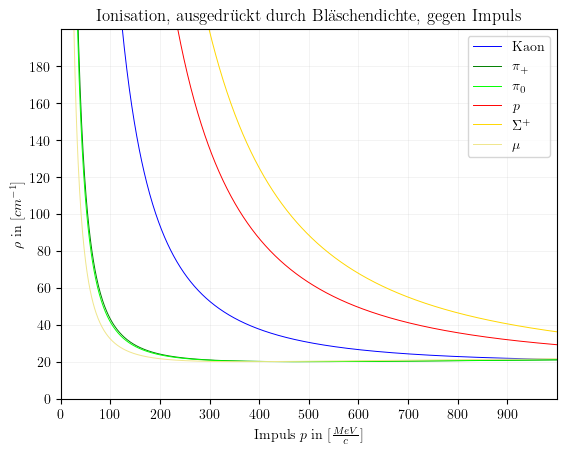

In [96]:
def delta_rho(rho_measured,delta_rho_measured_systematic):
    delta_rho_measured_statistical = np.sqrt(rho_measured)
    delta_rho_measured = delta_rho_measured_systematic + delta_rho_measured_statistical
    delta_rho = np.sqrt( (delta_rho_measured / s_p)**2 + (rho_measured * delta_s_p / s_p**2)**2 )
    return delta_rho

rho_kaon_measured = 52 # (49, 55) 
delta_rho_kaon_measured_systematic = 3

rho_kaon = rho_kaon_measured / (4/s_p) # per 4 cm -> per cm; länge mit vergrößerungsfaktor skaliert
delta_rho_kaon = delta_rho(rho_kaon_measured, delta_rho_kaon_measured_systematic)

ic(rho_kaon)
ic(delta_rho_kaon)

momentum_kaon = 810 # in MeV/c
mass_kaon = 493.7 # in MeV/c^2 , same value for rest energy

# some more values
mass_pion_charged = 139.57 # in MeV/c
mass_pion_zero = 135
mass_proton = 938.27
mass_sigma_plus = 1189 
mass_muon = 105.7 # same for both plus and minus  

# beta_kaon = np.sqrt( 1 - ( mass_kaon / (mass_kaon + momentum_kaon) )**2)
beta_kaon = momentum_kaon/np.sqrt(mass_kaon**2 + momentum_kaon**2)
ic(beta_kaon)

# calibrated terms inside the bracket of the bethe bloch formula
cal_bethebloch_log = np.log( (46880 * beta_kaon**2) / (1 - beta_kaon**2) )
cal_bethebloch_logbybeta = cal_bethebloch_log / beta_kaon**2
cal_bethebloch_bracket = cal_bethebloch_logbybeta - 1

calibration_value = rho_kaon / cal_bethebloch_bracket
ic(calibration_value)

# error of calibration value
delta_calibration_value = cal_bethebloch_bracket**(-1) * delta_rho_kaon
ic(delta_calibration_value)

def bubbledensity(calibrationfactor, mass, momentum):
    with np.errstate(divide='ignore', invalid='ignore'):
        # beta = np.sqrt( 1 - ( mass / (mass + momentum) )**2)
        beta = momentum/np.sqrt(mass**2 + momentum**2)
        beta = np.where(beta < 1e-2, 1e-2, beta)  # otherwise, numerical artifacts at p > 6   
        bethebloch_log = np.log( (46880 * beta**2) / (1 - beta**2) )
        bethebloch_logbybeta = bethebloch_log / beta**2
        bethebloch_bracket = bethebloch_logbybeta - 1
        
        return calibrationfactor * bethebloch_bracket 


p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots()
ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

ax.set_title('Ionisation, ausgedrückt durch Bläschendichte, gegen Impuls')
ax.set_ylim([0, 200]) 
ax.set_xlim([0,1000])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(0, 1000, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(0, 200, 20)) 
ax.legend()
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Eichkurven.pdf")
plt.show()

## Gesamtenergie und -impulserhaltung

\begin{align}
    E_{ges} &= E_{K^{-}} + E_{p} = \sqrt{m^{2}_{K^{-}} + \mathbf{p}_{K^{-}}^{2} } + m_{p} 
\end{align}

## Versuche/Topologien

In [97]:
# Maßstabsetzung, Impuls = 810MeV/c
r_gem1 = 230 # gemessener Krümmungsradius in cm
delta_r_gem1 = 7.5

df1 = parameterset(r_gem1, delta_r_gem1, "-", rho_kaon, delta_rho_kaon, 0)[4]
df1

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,230,7.5,132.101435,4.311364,0,10.0,811.882212,26.49721,22.634122,5.864928


## Versuch 2, Folie 223

In [98]:
# Folie 223
r_gem1 = 65
delta_r_gem1 = 2.5
theta_1 = -25 # possibly 360 - 25 = 335 
charge_1 = "-"
bubble_1 = "NaN"
delta_bubble_1 = "NaN"
angle_1 = 25

r_gem2 = 80 
delta_r_gem2 = 2.5
theta_2 = 9
charge_2 = "+"
bubble_2 = "NaN"
delta_bubble_2 = "NaN"
angle_2 = 9

r_gem3 = 90
delta_r_gem3 = 2.5
theta_3 = 14
charge_3 = "-"
bubble_3 = "NaN"
delta_bubble_3 = "NaN"
angle_3 = 14

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2,r_gem3])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,])
charge = [charge_1, charge_2, charge_3]
bubble = [bubble_1, bubble_2, bubble_3]
delta_bubble = [delta_bubble_1, delta_bubble_2, delta_bubble_3]
angle = [angle_1, angle_2, angle_3]

df2 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df2

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,65,2.5,37.333014,1.436774,25,10.0,229.444973,8.830268,NaN,NaN
2,+,80,2.5,45.948325,1.437231,9,10.0,282.393813,8.833078,NaN,NaN
3,-,90,2.5,51.691866,1.437588,14,10.0,317.693039,8.835274,NaN,NaN


## Versuch 3, Folie 229, Topologie 201

In [99]:
r_gem1 = 140
delta_r_gem1 = 5

bubble_1_measured = 47.5 # 47 and 48
delta_bubble_1_measured_systematic = 0.5

bubble_1 = bubble_1_measured / s_p
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "-"
angle_1 = -25



r_gem2 = 36
delta_r_gem2 = 2.5

bubble_2_measured = 53 # 50 and 56
delta_bubble_2_measured_systematic = 3
bubble_2 = bubble_2_measured / s_p
delta_bubble_2 = delta_rho(bubble_2_measured, delta_bubble_2_measured_systematic)
charge_2 = "-"
angle_2 = -22

r_gem3 = 42.5
delta_r_gem3 = 2.5
bubble_3_measured = 52.5 # 46 and 59
delta_bubble_3_measured_systematic = 6.5
bubble_3 = bubble_3_measured / s_p
delta_bubble_3 = delta_rho(bubble_3_measured, delta_bubble_3_measured_systematic)
charge_3 = "+"
angle_3 = 42

r_gem4 = 33
delta_r_gem4 = 2.5
bubble_4_measured = 59.5 # 58 and 61
delta_bubble_4_measured_systematic = 1.5
bubble_4 = bubble_4_measured / s_p
delta_bubble_4 = delta_rho(bubble_4_measured, delta_bubble_4_measured_systematic)
charge_4 = "+"
angle_4 = 57

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2,r_gem3,r_gem4])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2,delta_r_gem3,delta_r_gem4])
charge = [charge_1, charge_2, charge_3, charge_4]
bubble = np.array([bubble_1, bubble_2, bubble_3, bubble_4])
delta_bubble = np.array([delta_bubble_1, delta_bubble_2, delta_bubble_3, delta_bubble_4])
angle = np.array([angle_1, angle_2, angle_3, angle_4])

df3 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df3

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,140.0,5.0,80.409569,2.873831,-25,10.0,494.189172,17.662280,27.281818,4.245800
2,-,36.0,2.5,20.676746,1.436158,-22,10.0,127.077216,8.826482,30.440766,5.904567
3,+,42.5,2.5,24.410048,1.436265,42,10.0,150.021713,8.827142,30.153589,7.894997
4,+,33.0,2.5,18.953684,1.436114,57,10.0,116.487448,8.826215,34.174067,5.292085


## Versuch 4, Folie 239, Topologie 200

In [100]:
r_gem1 = 113
delta_r_gem1 = 5
bubble_1_measured = 53 # 52 and 54
delta_bubble_1_measured_systematic = 1
bubble_1 = bubble_1_measured / s_p
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "+"
angle_1 = -30.5

r_gem2 = 215
delta_r_gem2 = 7.5
bubble_2 = np.array([49,51])
bubble_2_measured = 50 # 49 and 51
delta_bubble_2_measured_systematic = 1
bubble_2 = bubble_2_measured / s_p
delta_bubble_2 = delta_rho(bubble_2_measured, delta_bubble_2_measured_systematic)
charge_2 = "-"
angle_2 = 56

# ----------------------------------------------------------------

r_gem = np.array([r_gem1,r_gem2])
delta_r_gem = np.array([delta_r_gem1,delta_r_gem2])
charge = [charge_1, charge_2]
bubble = np.array([bubble_1, bubble_2])
delta_bubble = np.array([delta_bubble_1, delta_bubble_1])
angle = np.array([angle_1, angle_2])

df4 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df4 

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,+,113,5.0,64.902010,2.873113,-30.5,10.0,398.881261,17.657866,30.440766,4.755893
2,-,215,7.5,123.486124,4.310896,56.0,10.0,758.933372,26.494335,28.717703,4.755893


## Versuch 5, Folie 285, Topologie 100

In [101]:
r_gem1 = 54
delta_r_gem1 = 2.5
bubble_1_measured = 49 # 48 and 50
delta_bubble_1_measured_systematic = 1
bubble_1 = bubble_1_measured / s_p
delta_bubble_1 = delta_rho(bubble_1_measured, delta_bubble_1_measured_systematic)
charge_1 = "-"
angle_1 = -58

# ----------------------------------------------------------------

r_gem = np.array([r_gem1])
delta_r_gem = np.array([delta_r_gem1])
charge = [charge_1]
bubble = np.array([bubble_1])
delta_bubble = np.array([delta_bubble_1])
angle = np.array([angle_1])


df5 = parameterset(r_gem,delta_r_gem, charge, bubble, delta_bubble, angle)[4]
df5

,charge,r_gem,delta_r_gem,r_real,delta_r_real,angle,delta_angle,momentum,delta_momentum,rho,delta_rho
1,-,54,2.5,31.01512,1.436499,-58,10.0,190.615824,8.828576,28.143349,4.59499


## Gesamttabelle
Energie

In [112]:
# Gesamtdataframe dfs

k=0
firstindex = []
secondindex = []
for df in dfs:
    indexlength = len(df.index)
    # firstindexentry = (np.ones(indexlength) + k).tolist() 
    firstindexentry = (np.ones(indexlength) + k).astype(int).tolist()
    firstindex.extend(firstindexentry) 
    j=0
    for j in range(1, indexlength + 1):
        secondindex.append(j)
    k += 1


total_df = pd.concat(dfs, axis=0)
total_df.index = pd.MultiIndex.from_arrays([firstindex, secondindex], names=["Versuch", "Teilchenspur"])

total_df.loc[(1,1),'delta_angle'] = np.float64(0) # no uncertainty on the first value
total_df

charge  r_gem  delta_r_gem      r_real  delta_r_real  \
Versuch Teilchenspur                                                        
1       1                 -  230.0          7.5  132.101435      4.311364   
2       1                 -   65.0          2.5   37.333014      1.436774   
        2                 +   80.0          2.5   45.948325      1.437231   
        3                 -   90.0          2.5   51.691866      1.437588   
3       1                 -  140.0          5.0   80.409569      2.873831   
        2                 -   36.0          2.5   20.676746      1.436158   
        3                 +   42.5          2.5   24.410048      1.436265   
        4                 +   33.0          2.5   18.953684      1.436114   
4       1                 +  113.0          5.0   64.902010      2.873113   
        2                 -  215.0          7.5  123.486124      4.310896   
5       1                 -   54.0          2.5   31.015120      1.436499   

                      angle  delta_angle    momentum  delta_momentum  \
Versuch Teilchenspur                                                   
1       1               0.0          0.0  811.882212       26.497210   
2       1              25.0         10.0  229.444973        8.830268   
        2               9.0         10.0  282.393813        8.833078   
        3              14.0         10.0  317.693039        8.835274   
3       1             -25.0         10.0  494.189172       17.662280   
        2             -22.0         10.0  127.077216        8.826482   
        3              42.0         10.0  150.021713        8.827142   
        4              57.0         10.0  116.487448        8.826215   
4       1             -30.5         10.0  398.881261       17.657866   
        2              56.0         10.0  758.933372       26.494335   
5       1             -58.0         10.0  190.615824        8.828576   

                            rho delta_rho  
Versuch Teilchenspur                       
1       1             22.634122  5.864928  
2       1                   NaN       NaN  
        2                   NaN       NaN  
        3                   NaN       NaN  
3       1             27.281818    4.2458  
        2             30.440766  5.904567  
        3             30.153589  7.894997  
        4             34.174067  5.292085  
4       1             30.440766  4.755893  
        2             28.717703  4.755893  
5       1             28.143349   4.59499

In [114]:
# Impulsberechnung
momentumcols = ['momentum', 'delta_momentum', 'angle', 'delta_angle']
momentum_df = [(index, total_df.loc[index, momentumcols].values.tolist()) for index in total_df.index]
ic(momentum_df)

# momentum_x_list = [values for _, values in momentum_df]
# ic(momentum_x_list)
# delta_momentum_x = np.sqrt( (np.cos(np.def2rad(angle))*delta_momentum)**2 + (momentum * np.sin(np.deg2rad(angle)) * delta_angle)**2) 
momentum_x_list = [[index, momentum * np.cos(np.deg2rad(angle)), 
                    np.sqrt( 
                        (np.cos(np.deg2rad(angle))*delta_momentum)**2 
                      + (momentum * np.sin(np.deg2rad(angle)) * np.deg2rad(delta_angle))**2
                           ) ] 
                   for index, [momentum, delta_momentum, angle, delta_angle] in momentum_df]
momentum_x_df = pd.DataFrame([(index, value, error) for index, value, error in momentum_x_list], 
                  columns=["Index", "Value", "Error"])
momentum_x_df.set_index(pd.MultiIndex.from_tuples(momentum_x_df["Index"]), inplace=True)
momentum_x_df.drop(columns=["Index"], inplace=True)
momentum_x_df = momentum_x_df.groupby(level=[0, 1]).sum()
# momentumx_df['delta_momentum_x'] = 
ic(momentum_x_df)
momentum_x_total_df = momentum_x_df.groupby(level=0).sum()
momentum_x_total_df ["Error"] = np.sqrt(momentum_x_df.groupby(level=0)["Error"].apply(lambda x: np.sum(x**2)))
ic(momentum_x_total_df)

momentum_y_list = [[index, momentum * np.sin(np.deg2rad(angle)),
                    np.sqrt( 
                        (np.sin(np.deg2rad(angle))*delta_momentum)**2 
                      + (momentum * np.cos(np.deg2rad(angle)) * np.deg2rad(delta_angle))**2
                           ) ] 
                   for index, [momentum, delta_momentum, angle, delta_angle] in momentum_df]
momentum_y_df = pd.DataFrame([(index, value, error) for index, value, error in momentum_y_list], 
                  columns=["Index", "Value", "Error"])
momentum_y_df.set_index(pd.MultiIndex.from_tuples(momentum_y_df["Index"]), inplace=True)
momentum_y_df.drop(columns=["Index"], inplace=True)
momentum_y_df = momentum_y_df.groupby(level=[0, 1]).sum()
ic(momentum_y_df)
momentum_y_total_df = momentum_y_df.groupby(level=0).sum()
momentum_y_total_df["Error"] = np.sqrt(momentum_y_df.groupby(level=0)["Error"].apply(lambda x: np.sum(x**2)))
ic(momentum_y_total_df)

ic| momentum_df: [((1, 1), [811.8822118660288, 26.49720973216118, 0.0, 0.0]),
                  ((2, 1), [229.4449729186603, 8.830267811400425, 25.0, 10.0]),
                  ((2, 2), [282.39381282296654, 8.833077861664341, 9.0, 10.0]),
                  ((2, 3), [317.69303942583736, 8.835273600518146, 14.0, 10.0]),
                  ((3, 1), [494.18917244019144, 17.662279983306373, -25.0, 10.0]),
                  ((3, 2), [127.07721577033493, 8.826482196793084, -22.0, 10.0]),
                  ((3, 3), [150.02171306220097, 8.827141791157622, 42.0, 10.0]),
                  ((3, 4), [116.4874477894737, 8.826214596195504, 57.0, 10.0]),
                  ((4, 1), [398.8812606124402, 17.657866417711755, -30.5, 10.0]),
                  ((4, 2), [758.9333719617225, 26.494335164838947, 56.0, 10.0]),
                  ((5, 1), [190.61582365550242, 8.828576182205007, -58.0, 10.0])]
ic| momentum_x_df:           Value       Error
                   1 1  811.882212   26.497210
                

,Value,Error
1,0.000000,0.000000
2,218.000663,81.252291
3,-58.378618,84.800798
4,426.736738,98.220786
5,-161.651386,19.153692


In [104]:
# Wertespalten
valcols = ['momentum', 'rho']
result = [(index, total_df.loc[index, valcols].values.tolist()) for index in total_df.index] # Werte mit Index
value_lists = [values for _, values in result] # Werte ohne Index
calc_list1 = [entry for i, entry in enumerate(result) if i != 1 and i != 2 and i != 3] # Werte ohne Versuch 2
calc_list2 = [entry for i, entry in enumerate(value_lists) if i != 1 and i != 2 and i != 3]

# Fehlerspalten
errcols = ['delta_momentum', 'delta_rho']
errors_full = [(index, total_df.loc[index, errcols].values.tolist()) for index in total_df.index] # Fehler mit Index
errors = [entry for i, entry in enumerate(errors_full) if i != 1 and i != 2 and i != 3] # Fehler ohne Versuch 2

In [105]:
# Gesamttabelle mit besseren Bezeichnungen (aufgrund der column Namen nicht für Datenanalyse geeignet)
total_df.columns = ['Ladung',
                    f'r$_{{gem}} [cm]$', f'$\\Delta r_{{gem}} [cm]$', 
                    f'$r_{{real}} [cm]$', f'$\\Delta r_{{real}} [cm]$', 
                    f'Winkel $\\phi [\u00B0]$', f'$\\Delta \\phi [\u00B0]$', 
                    f'$p [\\frac{{MeV}}{{c}}]$', f'$\\Delta p [\\frac{{MeV}}{{c}}]$', 
                    f'$\\rho_{{Bl}}$', f'$\\Delta \\rho_{{Bl}}$']

latex_table = total_df.to_latex(
    index=True, 
    escape=False,
    caption="Parameterwerte für die Impulsberechnung mittels Kinematik. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:momentumkinematic", 
    position="H",  
    column_format="llrrrrrrrrrrr", 
    float_format="{:0.4f}".format)

# print(latex_table)
total_df

Ladung  r$_{gem} [cm]$  $\Delta r_{gem} [cm]$  \
Versuch Teilchenspur                                                 
1       1                 -           230.0                    7.5   
2       1                 -            65.0                    2.5   
        2                 +            80.0                    2.5   
        3                 -            90.0                    2.5   
3       1                 -           140.0                    5.0   
        2                 -            36.0                    2.5   
        3                 +            42.5                    2.5   
        4                 +            33.0                    2.5   
4       1                 +           113.0                    5.0   
        2                 -           215.0                    7.5   
5       1                 -            54.0                    2.5   

                      $r_{real} [cm]$  $\Delta r_{real} [cm]$  \
Versuch Teilchenspur                                            
1       1                  132.101435                4.311364   
2       1                   37.333014                1.436774   
        2                   45.948325                1.437231   
        3                   51.691866                1.437588   
3       1                   80.409569                2.873831   
        2                   20.676746                1.436158   
        3                   24.410048                1.436265   
        4                   18.953684                1.436114   
4       1                   64.902010                2.873113   
        2                  123.486124                4.310896   
5       1                   31.015120                1.436499   

                      Winkel $\phi [°]$  $\Delta \phi [°]$  \
Versuch Teilchenspur                                         
1       1                           0.0                0.0   
2       1                          25.0               10.0   
        2                           9.0               10.0   
        3                          14.0               10.0   
3       1                         -25.0               10.0   
        2                         -22.0               10.0   
        3                          42.0               10.0   
        4                          57.0               10.0   
4       1                         -30.5               10.0   
        2                          56.0               10.0   
5       1                         -58.0               10.0   

                      $p [\frac{MeV}{c}]$  $\Delta p [\frac{MeV}{c}]$  \
Versuch Teilchenspur                                                    
1       1                      811.882212                   26.497210   
2       1                      229.444973                    8.830268   
        2                      282.393813                    8.833078   
        3                      317.693039                    8.835274   
3       1                      494.189172                   17.662280   
        2                      127.077216                    8.826482   
        3                      150.021713                    8.827142   
        4                      116.487448                    8.826215   
4       1                      398.881261                   17.657866   
        2                      758.933372                   26.494335   
5       1                      190.615824                    8.828576   

                     $\rho_{Bl}$ $\Delta \rho_{Bl}$  
Versuch Teilchenspur                                 
1       1              22.634122           5.864928  
2       1                    NaN                NaN  
        2                    NaN                NaN  
        3                    NaN                NaN  
3       1              27.281818             4.2458  
        2              30.440766           5.904567  
        3              30.153589           7.894997  
        4            

In [106]:
# Dataframe aufgetrennt wegen hoher Breite
mid = 7
df_total_1 = total_df.iloc[:,:mid]
df_total_2 = total_df.iloc[:,mid:]



In [107]:
# erste Hälfte
df_total_1
latex_table = df_total_1.to_latex(
    index=True, 
    escape=False,
    caption="Gemessene Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:measuredvalues", 
    position="H",  
    column_format="llrrrrrrr", 
    float_format="{:0.4f}".format)
# print(latex_table)

In [108]:
# zweite Hälfte
df_total_2
latex_table = df_total_2.to_latex(
    index=True, 
    escape=False,
    caption="Berechnete Parameterwerte. 1 und 2: Topologie 300, 3: Topologie 201, 4: Topologie 200, 5: Topologie 100",
    label="tab:calculatedvalues", 
    position="H",  
    column_format="llrrrrrrr", 
    float_format="{:0.4f}".format)
# print(latex_table)

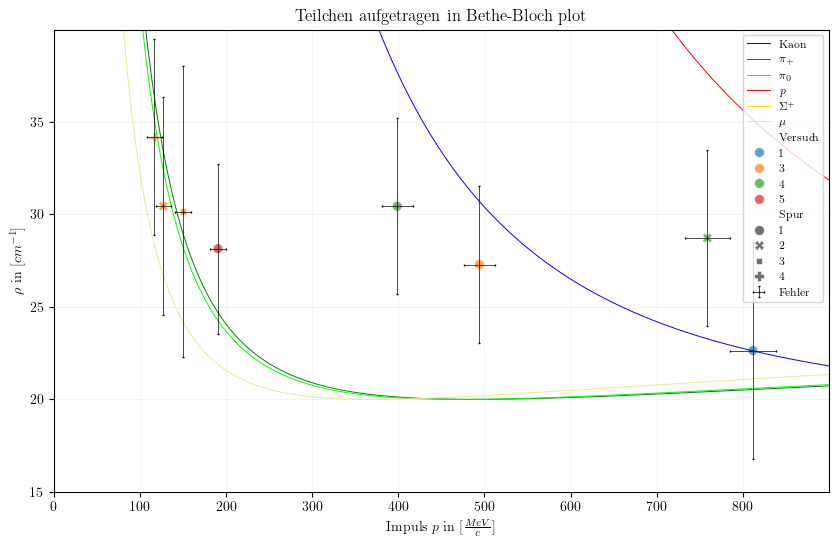

In [109]:
x_values = []
y_values = []
colors = []
labels = []
for (index1, index2), (x, y) in calc_list1:
    x_values.append(x)
    y_values.append(y)
    colors.append((index1, index2))
    labels.append(f'Versuch {index1}, Spur {index2}')

data = pd.DataFrame({
    'x': x_values,
    'y': y_values,
    'Versuch': [color[0] for color in colors],
    'Spur': [color[1] for color in colors],
    'label': labels
})




p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

sns.scatterplot(x='x', y='y', hue='Versuch', style='Spur', palette='tab10', data=data, s=50, alpha=0.7, ax=ax)


xvalue = [val[0] for _, val in calc_list1]
yvalue = [val[1] for _, val in calc_list1]
xerror = [error[0] for _, error in errors]
yerror = [error[1] for _, error in errors]
ax.errorbar(xvalue, yvalue, xerr=xerror, yerr=yerror, fmt='|', color='black', 
            label=f'Fehler', markersize=1, elinewidth=0.5, capsize=1, capthick=1)

ylimmin = 15
ylimmax = 40
xlimmin = 0
xlimmax = 900
ax.set_title('Teilchen aufgetragen in Bethe-Bloch plot')
ax.set_ylim([ylimmin, ylimmax]) 
ax.set_xlim([xlimmin,xlimmax])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(xlimmin, xlimmax, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(ylimmin, ylimmax, 5)) 
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Teilchenidentifikation.pdf")
plt.show()

Versuch 1 ist die Abmessung vom Eingangsstrahl und liegt wie erwartet auf der Kaonkurve. \
Versuch 3: \
Eingangsspur teilt sich auf in Spur 1 und 4, dann in Spur 2 und 3.
* Spur 1 ist negativ und hat einen hohen Impuls. Das einzige Teilchen, das als Zerfallsprodukt aufgrund der Ladung infrage kommt, is das negative pion. Das würde bedeuten, dass die Bläschendichte viel zu hoch abgeschätzt wurde.
* Spur 2 ist negativ und liegt auf den Pionkurven. Negatives pion würde Sinn ergeben.
* Spur 3 ist positiv und liegt ebenfalls auf den Pionkurven $\to$ positives Pion
* Spur 4 ist positiv und liegt auf den Pionkurven. Positives Pion
<br>

Versuch 4: \
Eingangsspur teilt sich auf in Spur 1 und 2.
* Spur 1 ist positiv und kann entweder ein positives pion oder ein proton sein. Da die Spur im y-Wert weit weg von der Protonkurve liegt, handelt es sich vermutlich um ein pion.
* Spur 2 ist negativ und könnte entweder kaon oder pion sein. Von den Kurven her betrachtet erschein kaon wahrscheinlicher.
<br>

Versuch 5: \
Spur 1 ist das negative pion. 

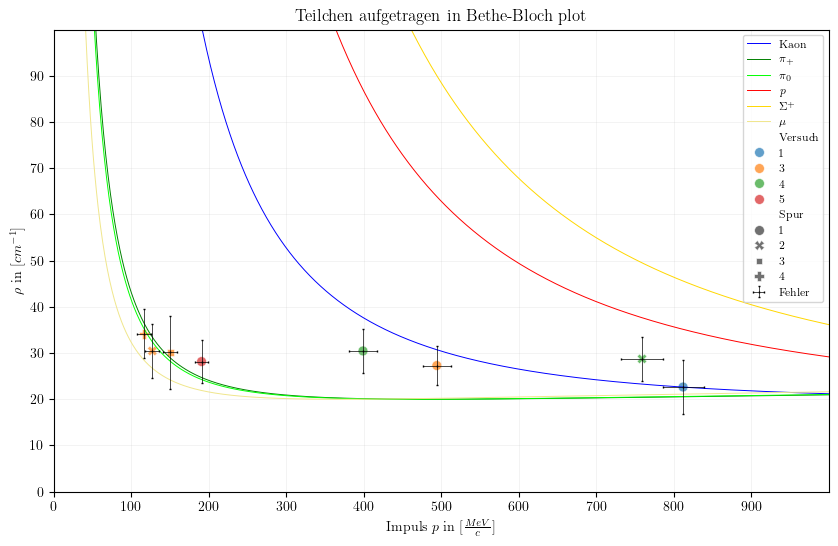

In [110]:
p = np.linspace(0,1000, 1000)
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(p, bubbledensity(calibration_value, mass_kaon, p), 'b', linewidth=.7, label='Kaon')
ax.plot(p, bubbledensity(calibration_value, mass_pion_charged, p), 'g', linewidth=.7, label=f'$\\pi_+$')
ax.plot(p, bubbledensity(calibration_value, mass_pion_zero, p), 'lime', linewidth=.7, label=f'$\\pi_0$')
ax.plot(p, bubbledensity(calibration_value, mass_proton, p), 'red', linewidth=.7, label=f'$p$')
ax.plot(p, bubbledensity(calibration_value, mass_sigma_plus, p), 'gold', linewidth=.7, label=f'$\\Sigma^+$')
ax.plot(p, bubbledensity(calibration_value, mass_muon, p), 'khaki', linewidth=.7, label=f'$\\mu$')

sns.scatterplot(x='x', y='y', hue='Versuch', style='Spur', palette='tab10', data=data, s=50, alpha=0.7, ax=ax)


xvalue = [val[0] for _, val in calc_list1]
yvalue = [val[1] for _, val in calc_list1]
xerror = [error[0] for _, error in errors]
yerror = [error[1] for _, error in errors]
ax.errorbar(xvalue, yvalue, xerr=xerror, yerr=yerror, fmt='|', color='black', 
            label=f'Fehler', markersize=1, elinewidth=0.5, capsize=1, capthick=1)

ylimmin = 0
ylimmax = 100
xlimmin = 0
xlimmax = 1000
ax.set_title('Teilchen aufgetragen in Bethe-Bloch plot')
ax.set_ylim([ylimmin, ylimmax]) 
ax.set_xlim([xlimmin,xlimmax])
ax.set(xlabel=f'Impuls $p$ in [$\\frac{{MeV}}{{c}}$]', ylabel=f' $\\rho$ in [$cm^{{-1}}$] ')
ax.set_xticks(np.arange(xlimmin, xlimmax, 100))  # X-axis ticks from 0 to 10 with a step of 2
ax.set_yticks(np.arange(ylimmin, ylimmax, 10)) 
ax.legend(loc='upper right', fontsize=8)
ax.grid(True, linewidth=0.5, alpha=0.2)
plt.savefig("plots/Teilchenidentifikation_large.pdf")
plt.show()